In [40]:
import numpy as np
import pandas as pd

In [41]:
# 디렉토리 파일 내에 있는 모든 파일 리스트 출력 
'''
from subprocess import check_output
print (check_output(["ls", "C:/Users/withy/바탕화면/KUBIG/24-2 데이터분석 스터디/4주차 Binary Classification Image Classfication"]).decode("utf8"))
'''

'\nfrom subprocess import check_output\nprint (check_output(["ls", "C:/Users/withy/바탕화면/KUBIG/24-2 데이터분석 스터디/4주차 Binary Classification Image Classfication"]).decode("utf8"))\n'

In [42]:
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize']=10,10
%matplotlib inline

In [43]:
train = pd.read_json("C:/Users/withy/바탕화면/KUBIG/24-2 데이터분석 스터디/4주차 Binary Classification Image Classfication/train.json")

In [44]:
test = pd.read_json("C:/Users/withy/바탕화면/KUBIG/24-2 데이터분석 스터디/4주차 Binary Classification Image Classfication/test.json")

Intro about the Data

In [46]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

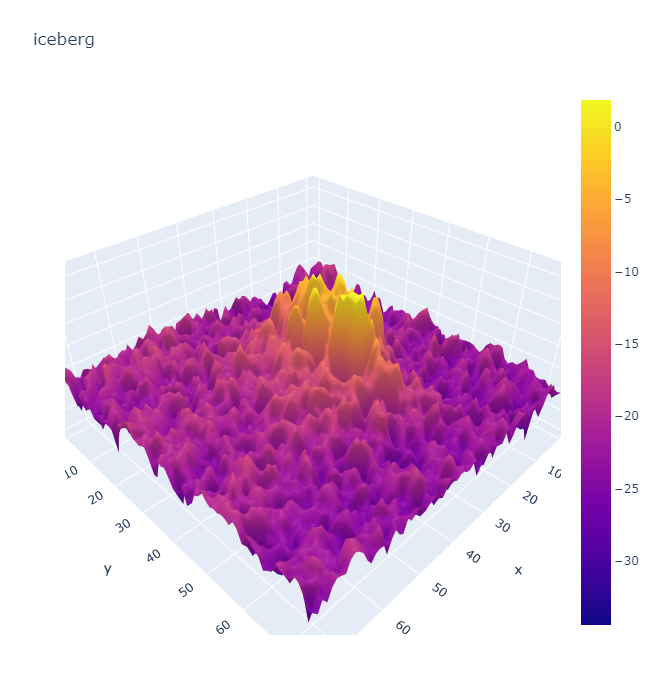

In [47]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):
    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name, 
        autosize=False,
        width=700, 
        height=700,
        margin=dict(
            l=65,
            r=50, 
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:],'iceberg')

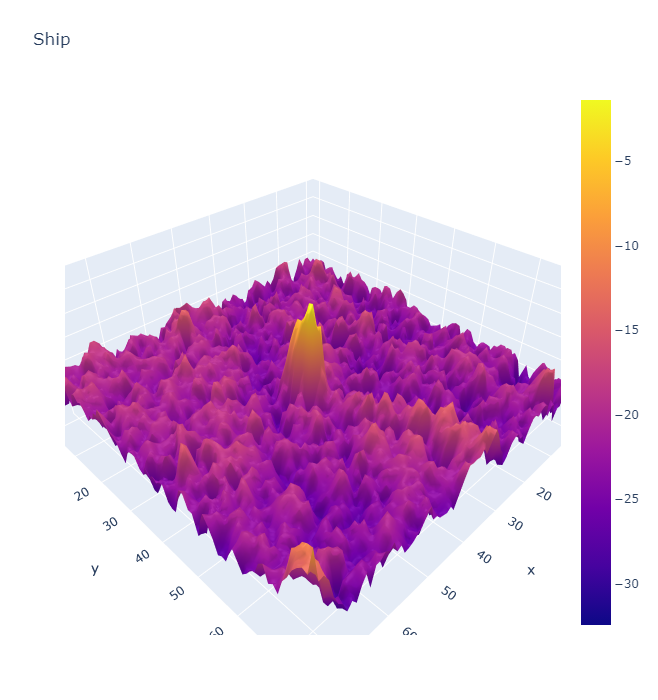

In [48]:
plotmy3d(X_band_1[14,:,:],'Ship')

In [49]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Define the model

In [73]:
def getModel():
    gmodel=Sequential()
    # layer 1
    gmodel.add(Conv2D(64, kernel_size=(3,3),activation='relu', input_shape=(75,75,3)))
    gmodel.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    gmodel.add(Dropout(0.2))

    # layer 2
    gmodel.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    gmodel.add(Dropout(0.2))

    # layer 3
    gmodel.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    gmodel.add(Dropout(0.2))

    #Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten
    gmodel.add(Flatten())

    #Dense layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=Adam,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel

In [75]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [77]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [79]:
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [68]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'gmodel' is not defined

In [70]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

NameError: name 'gmodel' is not defined

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)